## __EHT-Imaging Pipeline Execution__
### ___This script contains the code used in the `eht-imaging` pipeline written by the EHT Collaboration Team to produce images of the M87* Black Hole___
### ___Successful running of this notebook requires that the necessary environment is being used. In oder to ensure this is the case, please refer to the README provided.___
#### ___The code has been ported directly from the pipeline, and any changes are outlined inside hash-blocks (`#############`). The only changes made are in order to dynamically select what would be passed as command line arguments and to add some extra printing of the process.___

#### ___The observation day dropdown allows you to use both the lo and hi band data files of the day selected to create the image. If you wish to see only the output produced from the original pipeline, uncheck the `Print Progress?` checkbox. The `Save Image?` checkbox should be checked if you wish to save a `.pdf` version of the final image produced by the pipeline. Similarly, check the `Save Image Summary?` box to save a report of parameters surrounding the imaging process.___


In [1]:
import matplotlib
matplotlib.use('Agg')

import os
import argparse
import ehtim as eh
import numpy as np

################################################################################
%matplotlib inline
import pandas as pd
import ipywidgets as widgets

def resume_execution():
    print("Continuing execution with selected parameters.")

print_checkbox = widgets.Checkbox(value=True, description="Print Progress?", disabled=False, tooltip="Click to print progress")
day_dropdown = widgets.Dropdown(options=["095", "096", "100", "101"], value="095", description="Obs Day", tooltip="Select an observation day", disabled=False)
save_image_checkbox = widgets.Checkbox(value=True, description="Save Image PDF?", disabled=False, indent=False, tooltip="Click to save image")
save_summary_checkbox = widgets.Checkbox(value=True, description="Save Image Summary?", disabled=False, indent=False, tooltip="Click to save image summary pdf")
#continue_button = widgets.Button(description = 'continue', clear_output=False, wait=True)
#continue_button.on_click(resume_execution)
#widgets.Box([day_dropdown, print_checkbox, save_image_checkbox, save_summary_checkbox, continue_button])
widgets.Box([day_dropdown, print_checkbox, save_image_checkbox, save_summary_checkbox])
################################################################################

Welcome to eht-imaging! v 1.2.2 



Box(children=(Dropdown(description='Obs Day', options=('095', '096', '100', '101'), value='095'), Checkbox(val…

## __Define Parameters__
### ___In this stage of the pipeline, imaging parameters and the error budget are defined. These values will be used in later stages of the pipeline's execution.___

In [2]:
#-------------------------------------------------------------------------------
# Fiducial imaging parameters obtained from the eht-imaging parameter survey
#-------------------------------------------------------------------------------
zbl        = 0.60               # Total compact flux density (Jy)
prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities

# constant regularization weights
reg_term  = {'simple' : 100,    # Maximum-Entropy
             'tv'     : 1.0,    # Total Variation
             'tv2'    : 1.0,    # Total Squared Variation
             'l1'     : 0.0,    # L1 sparsity prior
             'flux'   : 1e4}    # compact flux constraint

# initial data weights - these are updated throughout the imaging pipeline
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes


#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'nfft'              # Type of Fourier transform ('direct', 'nfft', or 'fast')
npix      = 64                  # Number of pixels across the reconstructed image
fov       = 128*eh.RADPERUAS    # Field of view of the reconstructed image
maxit     = 100                 # Maximum number of convergence iterations for imaging
stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
reverse_taper_uas = 5.0         # Finest resolution of reconstructed features

# Specify the SEFD error budget
# (reported in First M87 Event Horizon Telescope Results III: Data Processing and Calibration)
SEFD_error_budget = {'AA':0.10,
                     'AP':0.11,
                     'AZ':0.07,
                     'LM':0.22,
                     'PV':0.10,
                     'SM':0.15,
                     'JC':0.14,
                     'SP':0.07}

# Add systematic noise tolerance for amplitude a-priori calibration errors
# Start with the SEFD noise (but need sqrt)
# then rescale to ensure that final results respect the stated error budget
systematic_noise = SEFD_error_budget.copy()
for key in systematic_noise.keys():
    systematic_noise[key] = ((1.0+systematic_noise[key])**0.5 - 1.0) * 0.25

# Extra noise added for the LMT, which has much more variability than the a-priori error budget
systematic_noise['LM'] += 0.15

## __Define Helper Functions__
### ___This phase of the pipeline defines two functions that will be used in later stages.___
* ___`rescale_zerobaselines` is used in the data preparation stage___
* ___`converge` is used in each round / iteration of the imaging stage___

In [3]:
#-------------------------------------------------------------------------------
# Define helper functions
#-------------------------------------------------------------------------------

# Rescale short baselines to excise contributions from extended flux.
# setting zbl < zbl_tot assumes there is an extended constant flux component of zbl_tot-zbl Jy
def rescale_zerobaseline(obs, totflux, orig_totflux, uv_max):
    multiplier = zbl / zbl_tot
    for j in range(len(obs.data)):
        if (obs.data['u'][j]**2 + obs.data['v'][j]**2)**0.5 >= uv_max: continue
        for field in ['vis','qvis','uvis','vvis','sigma','qsigma','usigma','vsigma']:
            obs.data[field][j] *= multiplier

# repeat imaging with blurring to assure good convergence
def converge(major=3, blur_frac=1.0):
    for repeat in range(major):
        init = imgr.out_last().blur_circ(blur_frac*res)
        imgr.init_next = init
        imgr.make_image_I(show_updates=False)

## __Data Preparation__
#### ___In this stage of the pipeline, the two data files (lo-band and hi-band) are loaded into seperate observation objects.___
#### ___The data is averaged based on individual scan lengths, and the two objects are combined into a single observation object.___
#### ___Sites with no measurements are flagged, and the zerobaselines are rescaled using the function defined previously.___

In [4]:
#-------------------------------------------------------------------------------
# Prepare the data
#-------------------------------------------------------------------------------
# load the two uvfits files
obs1 = eh.obsdata.load_uvfits('../data/uvfits/SR1_M87_2017_'+ day_dropdown.value +'_hi_hops_netcal_StokesI.uvfits')
obs2 = eh.obsdata.load_uvfits('../data/uvfits/SR1_M87_2017_'+ day_dropdown.value +'_lo_hops_netcal_StokesI.uvfits')

# Average data based on individual scan lengths
obs1.add_scans()
obs2.add_scans()
obs1 = obs1.avg_coherent(0.,scan_avg=True)
obs2 = obs2.avg_coherent(0.,scan_avg=True)

# Add a slight offset to avoid mixed closure products
obs2.data['time'] += 0.00001

# concatenate the observations into a single observation object
obs = obs1.copy()
obs.data = np.concatenate([obs1.data,obs2.data])

# Estimate the total flux density from the ALMA(AA) -- APEX(AP) zero baseline
zbl_tot   = np.median(obs.unpack_bl('AA','AP','amp')['amp'])
if zbl > zbl_tot:
    print('Warning: Specified total compact flux density ' +
          'exceeds total flux density measured on AA-AP!')

# Flag out sites in the obs.tarr table with no measurements
allsites = set(obs.unpack(['t1'])['t1'])|set(obs.unpack(['t2'])['t2'])
obs.tarr = obs.tarr[[o in allsites for o in obs.tarr['site']]]
obs = eh.obsdata.Obsdata(obs.ra, obs.dec, obs.rf, obs.bw, obs.data, obs.tarr,
                         source=obs.source, mjd=obs.mjd,
                         ampcal=obs.ampcal, phasecal=obs.phasecal)

obs_orig = obs.copy() # save obs before any further modifications

# Rescale short baselines to excize contributions from extended flux
if zbl != zbl_tot:
    rescale_zerobaseline(obs, zbl, zbl_tot, uv_zblcut)

# Order the stations by SNR.
# This will create a minimal set of closure quantities
# with the highest snr and smallest covariance.
obs.reorder_tarr_snr()



Loading uvfits:  ../data/uvfits/SR1_M87_2017_095_hi_hops_netcal_StokesI.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading uvfits:  ../data/uvfits/SR1_M87_2017_095_lo_hops_netcal_StokesI.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


## __Data Pre-Calibration__
#### ___To begin the data pre-calibration phase, a Gaussian prior image is created to be used in the first round of imaging.___
#### ___The data is then reverse tapered to enforce a maximum resolution on reconstructed features___
#### ___To end the pre-calibration phase, the data is self-calibrated using the observation object's built-in `selfcal` function___

In [5]:
#-------------------------------------------------------------------------------
# Pre-calibrate the data
#-------------------------------------------------------------------------------

obs_sc = obs.copy() # From here on out, don't change obs. Use obs_sc to track gain changes
res    = obs.res()  # The nominal array resolution: 1/(longest baseline)

# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image
gaussprior = eh.image.make_square(obs_sc, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# To avoid gradient singularities in the first step, add an additional small Gaussians
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

# Reverse taper the observation: this enforces a maximum resolution on reconstructed features
if reverse_taper_uas > 0:
    obs_sc = obs_sc.reverse_taper(reverse_taper_uas*eh.RADPERUAS)

# Add non-closing systematic noise to the observation
obs_sc = obs_sc.add_fractional_noise(sys_noise)

# Make a copy of the initial data (before any self-calibration but after the taper)
obs_sc_init = obs_sc.copy()

# Self-calibrate the LMT to a Gaussian model
# (Refer to Section 4's "Pre-Imaging Considerations")
print("Self-calibrating the LMT to a Gaussian model for LMT-SMT...")

obs_LMT = obs_sc_init.flag_uvdist(uv_max=2e9) # only consider the short baselines (LMT-SMT)
if reverse_taper_uas > 0:
    # start with original data that had no reverse taper applied.
    # Re-taper, if necessary
    obs_LMT = obs_LMT.taper(reverse_taper_uas*eh.RADPERUAS)

# Make a Gaussian image that would result in the LMT-SMT baseline visibility amplitude
# as estimated in Section 4's "Pre-Imaging Considerations".
# This is achieved with a Gaussian of size 60 microarcseconds and total flux of 0.6 Jy
gausspriorLMT = eh.image.make_square(obs, npix, fov)
gausspriorLMT = gausspriorLMT.add_gauss(0.6, (60.0*eh.RADPERUAS, 60.0*eh.RADPERUAS, 0, 0, 0))

# Self-calibrate the LMT visibilities to the gausspriorLMT image
# to enforce the estimated LMT-SMT visibility amplitude
caltab = eh.selfcal(obs_LMT, gausspriorLMT, sites=['LM'], gain_tol=1.0,
                    method='both', ttype=ttype, caltable=True)

# Spply the calibration solution to the full (and potentially tapered) dataset
obs_sc = caltab.applycal(obs_sc, interp='nearest', extrapolate=True)

Self-calibrating the LMT to a Gaussian model for LMT-SMT...
U-V flagged 278/336 visibilities
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 35/36 : [----------------------------- ]97%
self_cal time: 0.174377 s
No Calibration  Data for PV !


## __Image Reconstruction Cycle__
### ___This begins the four rounds of imaging.___

### __Round 1:__
#### ___This round of imaging begins by creating an image using the Gaussian prior as the prior image. This newly created image is then converged using the `converge` function previously defined.___
#### ___After the converge, the data is self-calibrated before moving to the second round of imaging.___

Round 1: Imaging with visibility amplitudes and closure quantities...
Initializing imager data products . . .
U-V flagged 32/336 visibilities
U-V flagged 304/336 visibilities
Imager run 1 
time: 0.762423 s
J: 21.927608
chi2_amp : 18.33 chi2_cphase : 2.08 chi2_logcamp : 2.64 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 0.760516 s
J: 21.955452
chi2_amp : 18.17 chi2_cphase : 1.94 chi2_logcamp : 2.54 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
time: 0.808128 s
J: 21.989991
chi2_amp : 18.20 chi2_cphase : 1.93 chi2_logcamp : 2.55 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
time: 0.819046 s
J: 22.000197
chi2_amp : 18.25 chi2_cphase : 1.94 chi2_logcamp : 2.55 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 37/38 : [------

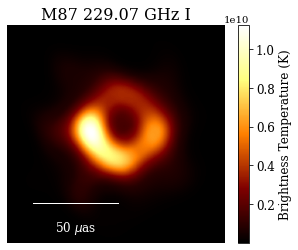

###############################################


In [6]:
#-------------------------------------------------------------------------------
# Reconstruct an image
#-------------------------------------------------------------------------------


# First  Round of Imaging
#-------------------------
print("Round 1: Imaging with visibility amplitudes and closure quantities...")

# Initialize imaging with a Gaussian image
imgr = eh.imager.Imager(obs_sc, gaussprior, prior_im=gaussprior,
                        flux=zbl, data_term=data_term, maxit=maxit,
                        norm_reg=True, systematic_noise=systematic_noise,
                        reg_term=reg_term, ttype=ttype, cp_uv_min=uv_zblcut, stop=stop)

# Imaging
imgr.make_image_I(show_updates=False)
converge()

# Self-calibrate to the previous model (phase-only);
# The solution_interval is 0 to align phases from high and low bands if needed
obs_sc = eh.selfcal(obs_sc, imgr.out_last(), method='phase', ttype=ttype, solution_interval=0.0)

################################################################################
if print_checkbox.value:
    print('########### New Image from Round 1 ############')
    imgr.out_last().display(cbar_unit=['Tb'],label_type='scale')
    print('###############################################')
################################################################################

### ___Round 2:___
#### ___This round of imaging begins by creating an image using the blurred image output from Round 1. This newly created image is then converged using the `converge` function previously defined.___
#### ___After the converge, the data is self-calibrated before moving to the final rounds of imaging.___

Round 2: Imaging with visibilities and closure quantities...
###### Blurred image at start of Round 2 ######


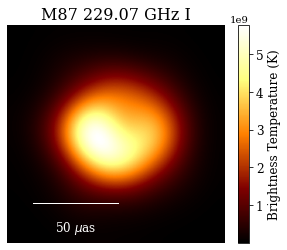

###############################################
Initializing imager data products . . .
U-V flagged 32/336 visibilities
U-V flagged 304/336 visibilities
Imager run 1 
time: 0.803170 s
J: 32.471701
chi2_cphase : 0.95 chi2_logcamp : 1.08 chi2_vis : 2.40 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 0.745280 s
J: 32.413905
chi2_cphase : 0.95 chi2_logcamp : 1.08 chi2_vis : 2.45 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
time: 0.916458 s
J: 32.468161
chi2_cphase : 0.95 chi2_logcamp : 1.08 chi2_vis : 2.44 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
time: 0.831625 s
J: 32.423469
chi2_cphase : 0.95 chi2_logcamp : 1.08 chi2_vis : 2.44 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 37/38 : [----------------------------- ]9

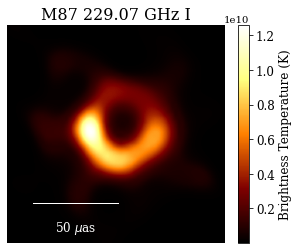

###############################################


In [7]:
# Second  Round of Imaging
#-------------------------
print("Round 2: Imaging with visibilities and closure quantities...")

# Blur the previous reconstruction to the intrinsic resolution of ~25 uas
init = imgr.out_last().blur_circ(res)

################################################################################
if print_checkbox.value:
    print("###### Blurred image at start of Round 2 ######")
    init.display(cbar_unit=['Tb'],label_type='scale')
    print('###############################################')

################################################################################

# Increase the weights on the data terms and reinitialize imaging
data_term_intermediate = {'vis':imgr.dat_terms_last()['amp']*10,
                          'cphase':imgr.dat_terms_last()['cphase']*10,
                          'logcamp':imgr.dat_terms_last()['logcamp']*10}

imgr = eh.imager.Imager(obs_sc, init, prior_im=gaussprior, flux=zbl,
                        data_term=data_term_intermediate, maxit=maxit, norm_reg=True,
                        systematic_noise=systematic_noise, reg_term = reg_term, ttype=ttype,
                        cp_uv_min=uv_zblcut, stop=stop)
# Imaging
imgr.make_image_I(show_updates=False)
converge()

# Self-calibrate to the previous model starting from scratch
# phase for all sites; amplitudes for LMT
obs_sc = eh.selfcal(obs_sc_init, imgr.out_last(), method='phase', ttype=ttype)
caltab = eh.selfcal(obs_sc, imgr.out_last(), sites=['LM'], method='both', gain_tol=gain_tol,
                    ttype=ttype, caltable=True)
obs_sc = caltab.applycal(obs_sc, interp='nearest',extrapolate=True)

################################################################################
if print_checkbox.value:
    print('########### New Image from Round 2 ############')
    imgr.out_last().display(cbar_unit=['Tb'],label_type='scale')
    print('###############################################')

################################################################################

### ___Rounds 3 & 4:___
#### ___These rounds of imaging begin by increasing the data weights used in the creation of the images. They then create an image using the blurred image output from the previous round of imaging. This newly created image is then converged using the `converge` function previously defined.___
#### ___After the converge, the data is self-calibrated before moving to the next round of imaging.___

Rounds 3+4: Imaging with visibilities and closure quantities...
###### Blurred image at start of Round 3 ######


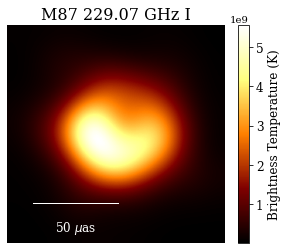

################################################
Initializing imager data products . . .
U-V flagged 32/336 visibilities
U-V flagged 304/336 visibilities
Imager run 1 
time: 0.909170 s
J: 37.373054
chi2_cphase : 0.76 chi2_logcamp : 0.98 chi2_vis : 1.25 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 0.811827 s
J: 37.333592
chi2_cphase : 0.76 chi2_logcamp : 0.98 chi2_vis : 1.26 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
time: 0.827112 s
J: 37.193301
chi2_cphase : 0.75 chi2_logcamp : 0.98 chi2_vis : 1.25 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
time: 0.941139 s
J: 37.238211
chi2_cphase : 0.75 chi2_logcamp : 0.97 chi2_vis : 1.26 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
########## New Image from Round 3 ###########


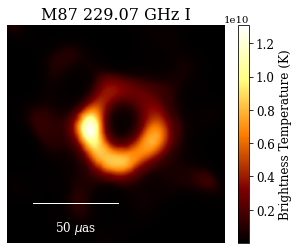

##############################################
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 37/38 : [----------------------------- ]97%
self_cal time: 4.491634 s
###### Blurred image at start of Round 4 ######


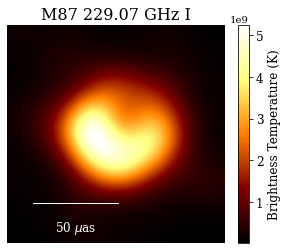

################################################
Initializing imager data products . . .
U-V flagged 32/336 visibilities
U-V flagged 304/336 visibilities
Imager run 1 
time: 0.778634 s
J: 32.269058
chi2_cphase : 0.75 chi2_logcamp : 0.95 chi2_vis : 0.86 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 0.709354 s
J: 32.055098
chi2_cphase : 0.75 chi2_logcamp : 0.95 chi2_vis : 0.86 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
time: 0.697952 s
J: 32.092350
chi2_cphase : 0.75 chi2_logcamp : 0.95 chi2_vis : 0.86 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
time: 0.760990 s
J: 32.274507
chi2_cphase : 0.75 chi2_logcamp : 0.95 chi2_vis : 0.86 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
########## New Image from Round 4 ###########


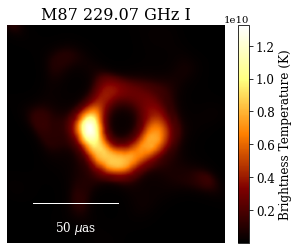

##############################################
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 37/38 : [----------------------------- ]97%
self_cal time: 4.968805 s


In [8]:
# Third and Fourth Rounds of Imaging
#-----------------------------------
print("Rounds 3+4: Imaging with visibilities and closure quantities...")

# Increase the data weights before imaging again
data_term_final = {'vis':imgr.dat_terms_last()['vis']*5,
                   'cphase':imgr.dat_terms_last()['cphase']*2,
                   'logcamp':imgr.dat_terms_last()['logcamp']*2}

# Repeat imaging twice
for repeat_selfcal in range(2):
    # Blur the previous reconstruction to the intrinsic resolution of ~25 uas
    init = imgr.out_last().blur_circ(res)
    
################################################################################
    # Print the intitial image - this is the last output image blurred
    if print_checkbox.value:
        print("###### Blurred image at start of Round %d ######" % (repeat_selfcal + 3))
        init.display(cbar_unit=['Tb'],label_type='scale')
        print('################################################')

################################################################################

    # Reinitialize imaging now using complex visibilities; common systematic noise
    imgr = eh.imager.Imager(obs_sc, init, prior_im=gaussprior, flux=zbl,
                            data_term=data_term_final, maxit=maxit, norm_reg=True,
                            systematic_noise=0.01, reg_term=reg_term, ttype=ttype,
                            cp_uv_min=uv_zblcut, stop=stop)
    # Imaging
    imgr.make_image_I(show_updates=False)
    converge()
    
################################################################################
    # Print the new image
    if print_checkbox.value:
        print('########## New Image from Round %d ###########' % (repeat_selfcal + 3))
        imgr.out_last().display(cbar_unit=['Tb'],label_type='scale')
        print('##############################################')

################################################################################
    
    # Self-calibrate
    caltab = eh.selfcal(obs_sc_init, imgr.out_last(), method='both',
                        sites=['SM','JC','AA','AP','LM','SP','AZ'],
                        ttype=ttype, gain_tol=gain_tol, caltable=True)
    obs_sc = caltab.applycal(obs_sc_init, interp='nearest',extrapolate=True)


## __Output / Save Final Image__
### ___In this stage of the pipeline, the image is saved as a `.fits` file and as the optional file types selected by the checkboxes at the beginning of execution.___
#### ___Outputs Generated:___
* ___single `.fits` file of the reconstructed image___
* ___single `.pdf` file of the reconstructed image (optional)___
* ___single `.pdf` file of the image summary output (optional)___

############# Final Image ##############


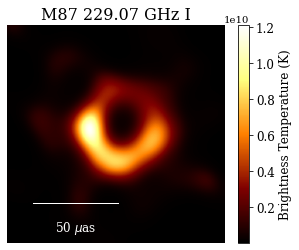

########################################


In [9]:
# Save the reconstructed image
im_out = imgr.out_last().copy()

# If an inverse taper was used, restore the final image
# to be consistent with the original data
if reverse_taper_uas > 0.0:
    im_out = im_out.blur_circ(reverse_taper_uas*eh.RADPERUAS)

# Save the final image
im_out.save_fits('./notebook-output/SR1_M87_2017_' + day_dropdown.value + '.fits')

################################################################################
print('############# Final Image ##############')
im_out.display(cbar_unit=['Tb'],label_type='scale')
print('########################################')
################################################################################

# Optionally save a pdf of the final image
if save_image_checkbox.value:
    pdfout = os.path.splitext('./notebook-output/SR1_M87_2017_' + day_dropdown.value)[0] + '.pdf'
    im_out.display(cbar_unit=['Tb'],label_type='scale',export_pdf=pdfout)

# Optionally generate a summary of the final image and associated data consistency metrics
if save_summary_checkbox.value:

    # Add a large gaussian component to account for the missing flux
    # so the final image can be compared with the original data
    im_addcmp = im_out.add_zblterm(obs_orig, uv_zblcut, debias=True)
    obs_sc_addcmp = eh.selfcal(obs_orig, im_addcmp, method='both', ttype=ttype)

    # Save an image summary sheet
    # Note! these chi2 values will not be identical to what is shown in the paper
    # because they are combining high and low band
    matplotlib.pyplot.close('all')
    outimgsum = os.path.splitext('./notebook-output/SR1_M87_2017_' + day_dropdown.value)[0] + '_imgsum.pdf'
    eh.imgsum(im_addcmp, obs_sc_addcmp, obs_orig, outimgsum ,cp_uv_min=uv_zblcut)